Offline best k: 114 total: 0.39498151025989964


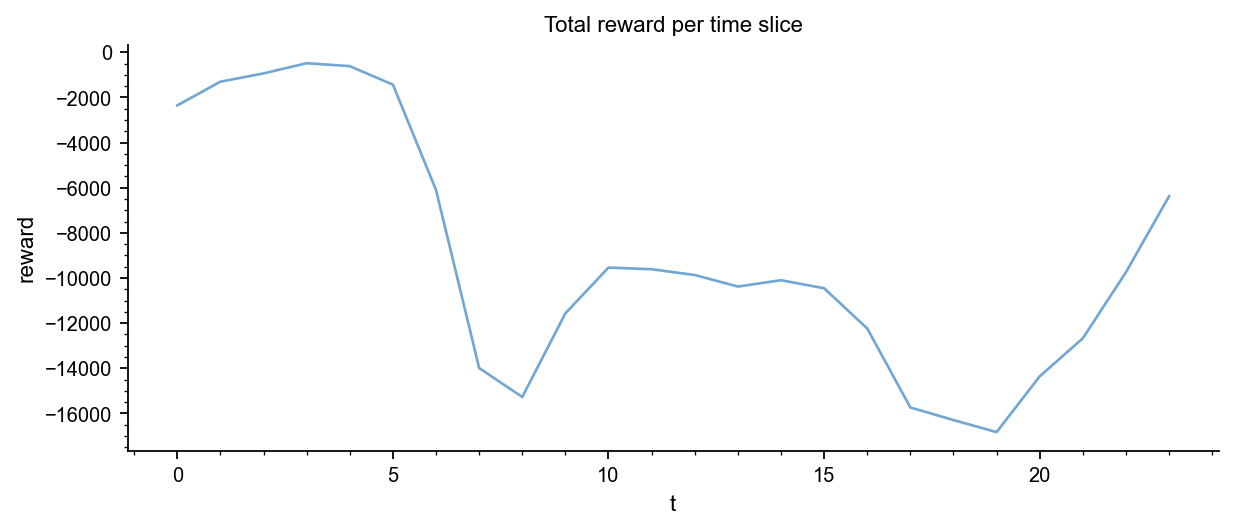

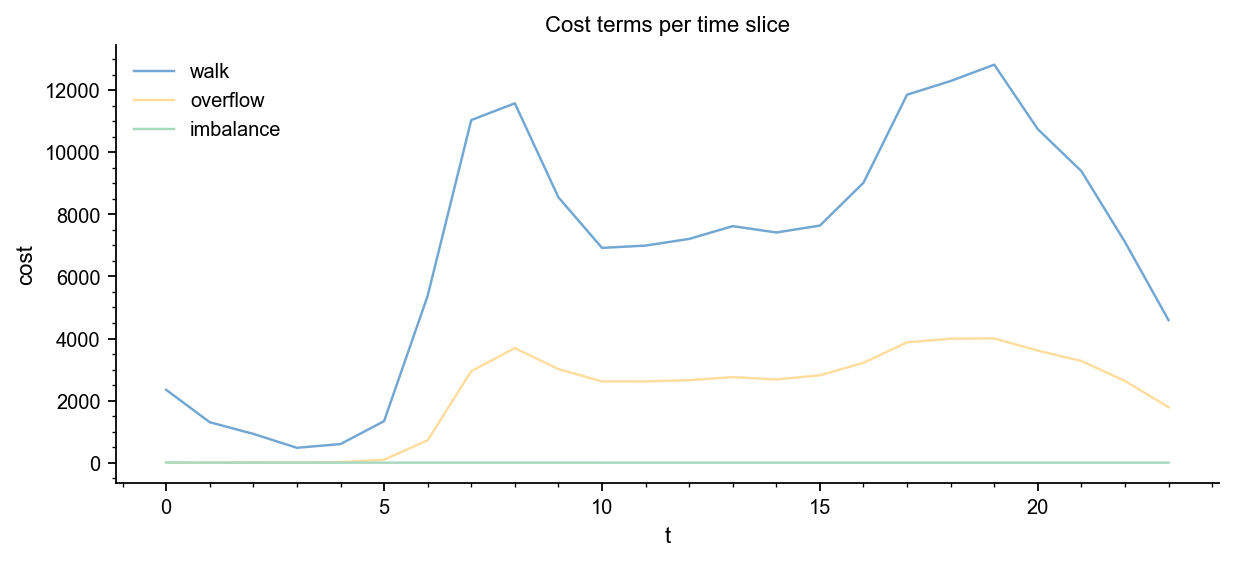

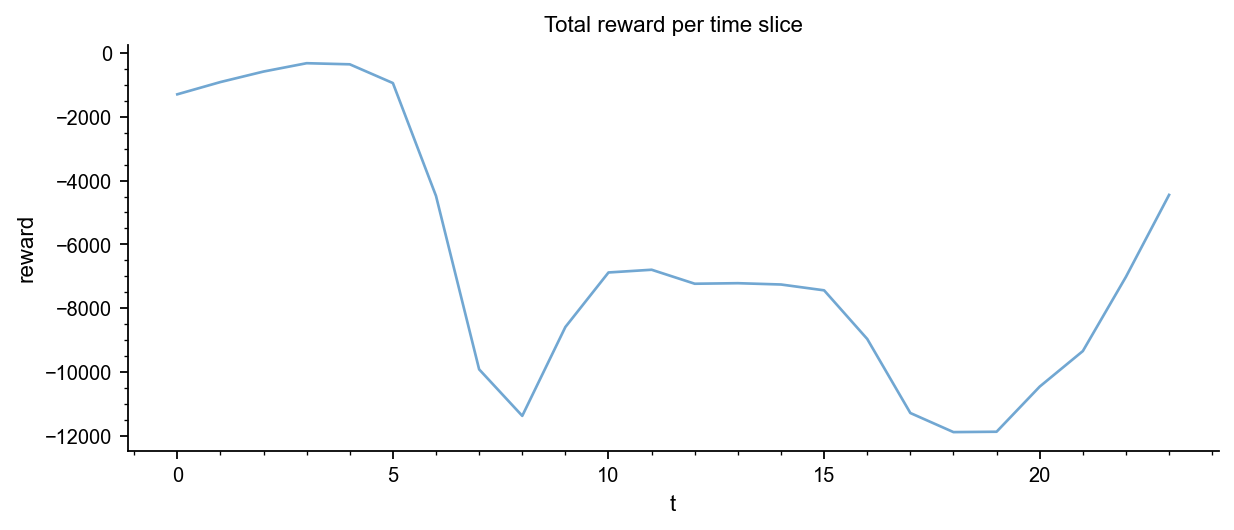

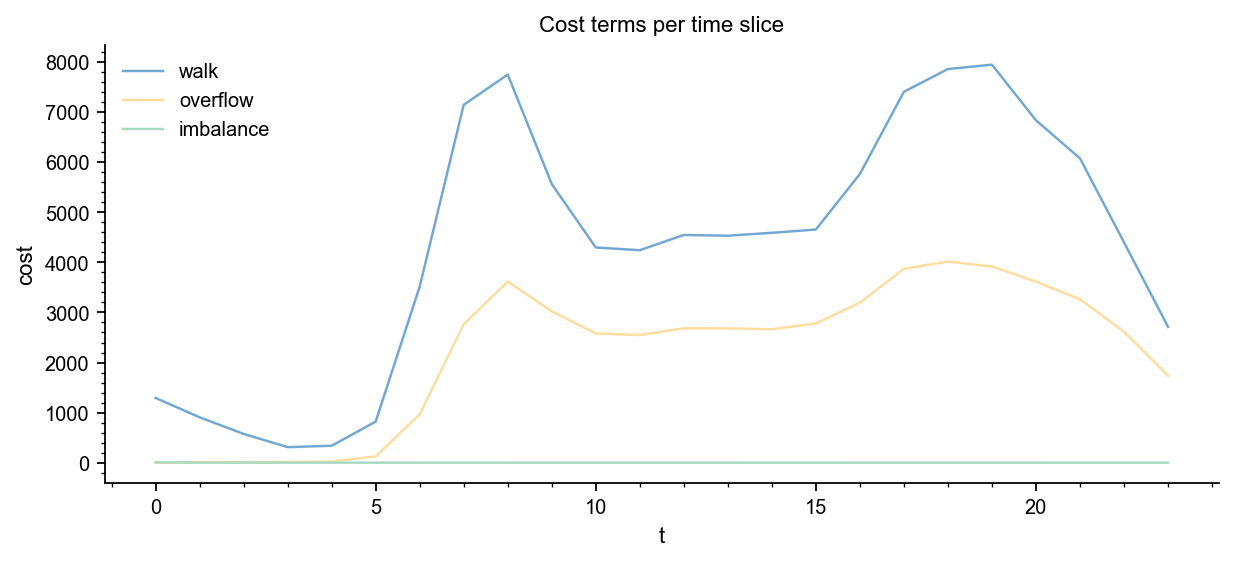

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from src.data_prep import load_data
from src.offline_model import random_search
from src.online_policy import LinUCB
from src.simulate import BikeEnv
from src.viz import set_journal_style, plot_online_curves

set_journal_style()


# 读取数据
D, Dist, cap, meta, stations = load_data("data/processed")

J_COUNT = len(meta["J_ids"])
I_COUNT = len(meta["I_ids"])
GRID_N = int(np.sqrt(I_COUNT))

# 先做一次离线选址（作为在线部分的固定站点集合 y_best）
BUDGET_MIN_RATIO = 0.40
BUDGET_MAX_RATIO = 0.80
budget_min = int(np.ceil(BUDGET_MIN_RATIO * J_COUNT))
budget_max = int(np.floor(BUDGET_MAX_RATIO * J_COUNT))
n_samples = int(8 * J_COUNT)

alpha_walk = 1.0
lam_over = 1.0
mu_imb = 1.0
eta_build = 0.6

best, _ = random_search(
    D, Dist, cap,
    budget_min=budget_min,
    budget_max=budget_max,
    n_samples=n_samples,
    alpha_walk=alpha_walk,
    lam_over=lam_over,
    mu_imb=mu_imb,
    eta_build=eta_build,
    normalize_terms=True,
    station_penalty_mode="minmax",
    station_penalty_power=2.0,
    rng_seed=42,
)

y_best = best["y"]
print("Offline best k:", int(y_best.sum()), "total:", best["total"])

# baseline: no policy（随机在最近 3 个站点里选）
env = BikeEnv(D, Dist, cap, y_best,
             alpha_walk=alpha_walk,
             lam_over=lam_over,
             mu_imb=mu_imb,
             rng_seed=0)
hist_baseline = env.run_episode(policy=None)
plot_online_curves(hist_baseline)

# LinUCB policy
dim = 5  # 与 build_feature_vector 保持一致
policy = LinUCB(dim=dim, alpha=1.0)
env2 = BikeEnv(D, Dist, cap, y_best,
              alpha_walk=alpha_walk,
              lam_over=lam_over,
              mu_imb=mu_imb,
              rng_seed=1)
hist_ucb = env2.run_episode(policy=policy)
plot_online_curves(hist_ucb)

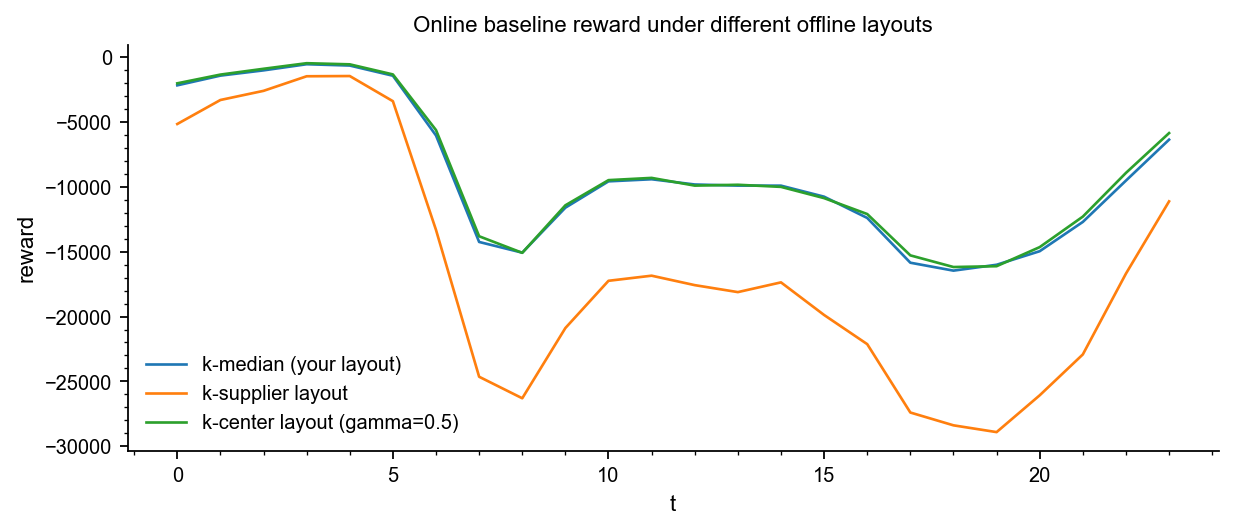

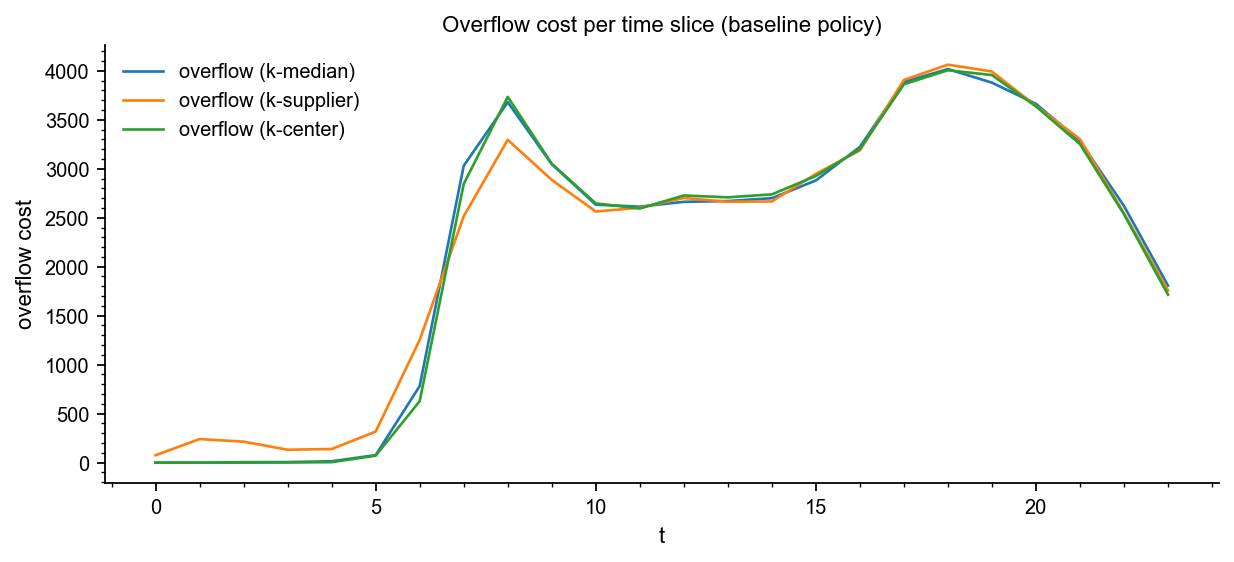

In [2]:

# =========================================================
# 4) (Optional) Compare ONLINE curves under different OFFLINE layouts
#    This keeps your original demo intact and adds a side-by-side baseline.
# =========================================================
from src.offline_model import greedy_kcenter, greedy_ksupplier

k = int(y_best.sum())
y_ksupplier = greedy_ksupplier(D, Dist, k, seed=0)
y_kcenter = greedy_kcenter(D, Dist, k, seed=0, gamma=0.5)

def run_baseline(y_layout, seed):
    env = BikeEnv(D, Dist, cap, y_layout,
                 alpha_walk=alpha_walk,
                 lam_over=lam_over,
                 mu_imb=mu_imb,
                 rng_seed=seed)
    return env.run_episode(policy=None)

hist_kmedian = run_baseline(y_best, seed=10)
hist_ksupplier = run_baseline(y_ksupplier, seed=11)
hist_kcenter = run_baseline(y_kcenter, seed=12)

import numpy as np
import matplotlib.pyplot as plt

t = np.arange(len(hist_kmedian["total_reward"]))
plt.figure(figsize=(7.6, 3.2))
plt.plot(t, hist_kmedian["total_reward"], label="k-median (your layout)")
plt.plot(t, hist_ksupplier["total_reward"], label="k-supplier layout")
plt.plot(t, hist_kcenter["total_reward"], label="k-center layout (gamma=0.5)")
plt.xlabel("t")
plt.ylabel("reward")
plt.title("Online baseline reward under different offline layouts")
plt.legend()
plt.show()

plt.figure(figsize=(7.6, 3.4))
plt.plot(t, hist_kmedian["overflow_cost"], label="overflow (k-median)")
plt.plot(t, hist_ksupplier["overflow_cost"], label="overflow (k-supplier)")
plt.plot(t, hist_kcenter["overflow_cost"], label="overflow (k-center)")
plt.xlabel("t")
plt.ylabel("overflow cost")
plt.title("Overflow cost per time slice (baseline policy)")
plt.legend()
plt.show()
